# BirdSet Fine-Tuning Tutorial

This notebook details how to fine-tune models on BirdSet data.

## Helper Functions

These functions are just helper functions for the code below. These can be ignored for now and looked up when they are used in the notebook.  
Not all BirdSet code used, is turned into helper functions for this notebook as there are too many to do that, however, the most abstracting parts are.

### Event Limiting

This function limits event extraction per specification. If needed it can limit the extracted events per class, per extracted file, or of both.

In [76]:
import pandas as pd
import random
from tqdm import tqdm
from collections import Counter

def smart_sampling(dataset, label_name, class_limit, event_limit):
        def _unique_identifier(x, labelname):
            file = x["filepath"]
            label = x[labelname]
            return {"id": f"{file}-{label}"}

        class_limit = class_limit if class_limit else -float("inf")
        dataset = dataset.map(
            lambda x: _unique_identifier(x, label_name), desc="sampling: unique-identifier"
        )
        df = pd.DataFrame(dataset)
        path_label_count = df.groupby(["id", label_name], as_index=False).size()
        path_label_count = path_label_count.set_index("id")
        class_sizes = df.groupby(label_name).size()

        for label in tqdm(class_sizes.index, desc="sampling"):
            current = path_label_count[path_label_count[label_name] == label]
            total = current["size"].sum()
            most = current["size"].max()

            while total > class_limit or most != event_limit:
                largest_count = current["size"].value_counts()[current["size"].max()]
                n_largest = current.nlargest(largest_count + 1, "size")
                to_del = n_largest["size"].max() - n_largest["size"].min()

                idxs = n_largest[n_largest["size"] == n_largest["size"].max()].index
                if (
                    total - (to_del * largest_count) < class_limit
                    or most == event_limit
                    or most == 1
                ):
                    break
                for idx in idxs:
                    current.at[idx, "size"] = current.at[idx, "size"] - to_del
                    path_label_count.at[idx, "size"] = (
                        path_label_count.at[idx, "size"] - to_del
                    )

                total = current["size"].sum()
                most = current["size"].max()

        event_counts = Counter(dataset["id"])

        all_file_indices = {label: [] for label in event_counts.keys()}
        for idx, label in enumerate(dataset["id"]):
            all_file_indices[label].append(idx)

        limited_indices = []
        for file, indices in all_file_indices.items():
            limit = path_label_count.loc[file]["size"]
            limited_indices.extend(random.sample(indices, limit))

        dataset = dataset.remove_columns("id")
        return dataset.select(limited_indices)

### One-Hot Encoding

This function one hot encodes the given labels. This is needed for BirdSet's multilabel training as a `MultilabelMix` transform gets applied that mixes the labels and input values of some inputs into one to simulate multilabel data. Without that multilabel data is only present in the `test_5s` splits of BirdSet's datasets.

In [77]:
import torch

def classes_one_hot(batch, num_classes):
        """
        Converts class labels to one-hot encoding.

        This method takes a batch of data and converts the class labels to one-hot encoding.
        The one-hot encoding is a binary matrix representation of the class labels.

        Args:
            batch (dict): A batch of data. The batch should be a dictionary where the keys are the field names and the values are the field data.

        Returns:
            dict: The batch with the "labels" field converted to one-hot encoding. The keys are the field names and the values are the field data.
        """
        label_list = [y for y in batch["labels"]]
        class_one_hot_matrix = torch.zeros(
            (len(label_list), num_classes), dtype=torch.float
        )

        for class_idx, idx in enumerate(label_list):
            class_one_hot_matrix[class_idx, idx] = 1

        class_one_hot_matrix = torch.tensor(class_one_hot_matrix, dtype=torch.float32)
        return {"labels": class_one_hot_matrix}

### Basic Transforms Wrapper

This class will help in handling the application of transforms on the data as well as converting the waveforms to spectrogramms. Transforms are stored in a list and then applied in the list order when a call to this class is made.

In [78]:
from dataclasses import dataclass
from torchaudio.transforms import Spectrogram, MelScale
from birdset.datamodule.components.resize import Resizer
from birdset.datamodule.components.augmentations import PowerToDB
import numpy as np
import torch_audiomentations
import torchvision.transforms


@dataclass
class CustomProcessingConfig:
    spectrogram_conversion: Spectrogram | None = Spectrogram(
            n_fft=1024,
            hop_length=320,
            power=2.0,
    )
    resizer: Resizer | None = Resizer(
            db_scale=True,
    ),
    melscale_conversion: MelScale | None = MelScale(
            n_mels=128,
            sample_rate=32000,
            n_stft=513, # n_fft//2+1
    ),
    dbscale_conversion: PowerToDB | None = PowerToDB(),
    normalize_spectrogram: bool = True,
    mean: float = -4.268,
    std: float = -4.569,

class BasicTransformsWrapper():
    def __init__(self,
                 wav_transforms,
                 spec_transforms,
                 decoding,
                 feature_extractor,
                 nocall_sampler,
                 processing_config = CustomProcessingConfig):
        self.wav_transforms = torch_audiomentations.Compose(
            transforms=wav_transforms,
            output_type="object_dict")
        self.spec_transforms = torchvision.transforms.Compose(
            transforms=spec_transforms
        )
        self.processing = processing_config
        self.nocall_sampler = nocall_sampler
        self.decoding = decoding
        self.feature_extractor = feature_extractor

    def __call__(self, batch, **kwds):

        batch = self.decoding(batch)

        waveform_batch = self._get_waveform_batch(batch)

        input_values = waveform_batch["input_values"]
        input_values = input_values.unsqueeze(1)
        labels = torch.tensor(batch["labels"])

        input_values, labels = self._waveform_augmentation(input_values, labels)
        
        if self.nocall_sampler:
            input_values, labels = self.nocall_sampler(input_values, labels)

        if self.processing.spectrogram_conversion is not None:
            spectrograms = self.processing.spectrogram_conversion(input_values)

            if self.spec_transforms:
                spectrograms = self.spec_transforms(spectrograms)

            if self.processing.melscale_conversion:
                spectrograms = self.processing.melscale_conversion(spectrograms)

            if self.processing.dbscale_conversion:
                spectrograms = self.processing.dbscale_conversion(spectrograms)

            if self.processing.resizer:
                spectrograms = self.processing.resizer.resize_spectrogram_batch(spectrograms)
                
            if self.processing.normalize_spectrogram:
                spectrograms = (spectrograms - self.processing.mean) / self.processing.std
            
            input_values = spectrograms

        # values in labels need to be of type float for further use
        labels = labels.to(torch.float16)

        return {"input_values": input_values, "labels": labels}

    def _get_waveform_batch(self, batch):
        waveform_batch = [audio["array"] for audio in batch["audio"]]
        
        # extract/pad/truncate
        max_length = int(int(self.feature_extractor.sampling_rate) * int(self.decoding.max_len))
        waveform_batch = self.feature_extractor(
            waveform_batch,
            padding='max_length',
            max_length=max_length, 
            truncation=True,
            return_attention_mask=True
        )
        
        return waveform_batch

    def _waveform_augmentation(self, input_values, labels):
        labels = labels.unsqueeze(1).unsqueeze(1)
        output_dict = self.wav_transforms(
            samples=input_values, 
            sample_rate=self.feature_extractor.sampling_rate,
            targets=labels
        )
        labels = output_dict.targets.squeeze(1).squeeze(1)
        
        return output_dict.samples, labels

### Custom Datamodule

When using a lightning trainer you can either pass a Datamodule or the Dataloaders needed for the planed task. Typically a Datamodule would load the data, preprocess it and apply transforms. In this case the datamodule will only hold the data and provide Dataloaders. The other steps are done separately so as to not abstract each step too much.  
For a more typical implementation of Datamodules you should look into the `BirdSetDataModule` in `birdset/datamodules/birdset_datamodule.py`.

In [79]:
import lightning as L
from torch.utils.data import DataLoader

class CustomDatamodule(L.LightningDataModule):
    def __init__(self,
                dataset,
                batch_size,
                num_workers,
                num_classes,
                task):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.train_batch_size = batch_size
        self.num_workers= num_workers
        self.num_classes = num_classes
        self.task = task
        self.len_trainset = len(dataset["train"])

    def setup(self, stage):
        pass 

    def train_dataloader(self):
        return DataLoader(dataset=self.dataset["train"], batch_size=self.batch_size, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(dataset=self.dataset["valid"], batch_size=self.batch_size, num_workers=self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(dataset=self.dataset["test"], batch_size=self.batch_size, num_workers=self.num_workers)

### Custom Lightning Module

This snippet defines a custom LightningModule. It is needed as a wrapper for models loaded from Hugging Face if you want to train using the Lightning trainer, as it expects an instance of `Lightning.LightningModule` and models loaded from Hugging Face are not.

In [80]:
from transformers import ASTForAudioClassification, ConvNextForImageClassification
from torchmetrics import AUROC, MetricCollection
from birdset.modules.metrics.multilabel import TopKAccuracy, cmAP
import lightning as l
import torch.nn as nn
import torch
from transformers import AdamW
    
class ConvNextClassifierLightningModule(l.LightningModule):
    def __init__(
            self,
            num_classes,
            num_epochs,
            ):
        super(ConvNextClassifierLightningModule, self).__init__()
        self.model = ConvNextForImageClassification.from_pretrained(
            "DBD-research-group/ConvNeXT-Base-BirdSet-XCL",
            num_labels=num_classes,
            ignore_mismatched_sizes=True
            )

        self.num_classes = num_classes
        self.num_epochs = num_epochs
        self.loss = nn.BCEWithLogitsLoss()
        self.main_metric = cmAP(
            num_labels=num_classes,
            thresholds=None
        )
        self.other_metrics = MetricCollection({
            "MultilabelAUROC": AUROC(
                task="multilabel",
                num_labels=num_classes,
                average="macro",
                thresholds=None
            ),
            "T1Accuracy": TopKAccuracy(topk=1)
        })
    
    def forward(self, pixel_values):
        outputs = self.model(pixel_values=pixel_values)
        return outputs.logits
        
    def common_step(self, batch, batch_idx):
        values = batch["input_values"]
        labels = batch["labels"]
        logits = self(values)
        
        loss = self.loss(logits, labels)
        predictions = torch.sigmoid(logits)
        
        return loss, predictions
      
    def training_step(self, batch, batch_idx):
        loss, preds = self.common_step(batch, batch_idx)     
        self.log(
            f"train/{self.loss.__class__.__name__}",
            loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True
        )

        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, preds = self.common_step(batch, batch_idx)     
        self.log(
            f"val/{self.loss.__class__.__name__}",
            loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True
        )

        return loss

    def test_step(self, batch, batch_idx):
        loss, preds = self.common_step(batch, batch_idx)   
        self.log(
            f"test/{self.loss.__class__.__name__}",
            loss, 
            on_step=False,
            on_epoch=True,
            prog_bar=True
        )
        self.main_metric(preds, batch["labels"].int())
        self.log(
            f"test/{self.main_metric.__class__.__name__}",
            self.main_metric,
            on_step=False,
            on_epoch=True,
            prog_bar=False
        )
        self.other_metrics(preds, batch["labels"].int())
        self.log_dict(
            self.other_metrics,
            on_step=False,
            on_epoch=True,
            prog_bar=False
        )
    

        return loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=5e-5)
    

## Loading Data

There are two ways to use BirdSet datasets:

1. using BirdSet's inbuild datamodules which manage the loading, preparing and transformation of data
2. loading, preparing and transforming the data manually

Both of these options are shown in this section. The configurations shown here are taken from the configurations that are used in BirdSet's training proccesses, although some things (e.g. batch size) may differ.

### Using BirdSet Datamodules

This section shows how to load a dataset with BirdSets datamodules. These are the modules that handle the loading, preparing and transforming of data. They have a great amount of customizability. For more information about what the parameters of the various configs do, a look into the `birdset-pipeline_tutorial` notebook is advised. The configuration of datamodules is explained there.

Please note that `PretrainDataModule` should be used for the `XCL` and `XCM` datasets as they do not have `test` splits.

#### Configuring Transforms

Here all the relevant transforms as well as event decoding and extracting is confifigured. For a more granular look into which configurations apply to what please refer to the `Loading Data Manually` section or the `birdset-pipeline-tutorial`.

Please note that the usage of `NoCallMixer` and `AddBackgroundNoise` requires extra soundfiles that can be used as such. You can utilize a script provided by BirdSet under `resources/utils/download_background_noise.py` to download files that can be used. Alternatively you can set `nocall` to `None` and comment out `AddBackgroundNoise` to not use them for now.

In [65]:
from birdset.datamodule.components.transforms import BirdSetTransformsWrapper, PreprocessingConfig
from birdset.datamodule.components.event_decoding import EventDecoding
from birdset.datamodule.components.feature_extraction import DefaultFeatureExtractor
from birdset.datamodule.components.augmentations import NoCallMixer, MultilabelMix, AddBackgroundNoise, PowerToDB
from birdset.datamodule.components.resize import Resizer
from torch_audiomentations import AddColoredNoise, Gain
from torchaudio.transforms import Spectrogram, MelScale, FrequencyMasking, TimeMasking
from torchvision.transforms import RandomApply

decoder = EventDecoding(
    min_len=1,
    max_len=5,
    sampling_rate=32000,
    extension_time=8,
    extracted_interval=5
)

feature_extractor = DefaultFeatureExtractor(
    feature_size=1,
    sampling_rate=32000,
    padding_value=0.0,
    return_attention_mask=False
)

nocall = NoCallMixer(
    directory="/mnt/stud/work/rantjuschin/datasets/background_noise/",
    p=0.075,
    sampling_rate=32000,
    length=5
)

wav_transforms = {
    "multilabel_mix": MultilabelMix(
        p=0.7,
        min_snr_in_db=3.0,
        max_snr_in_db=30.0,
        mix_target="union"
    ),
    "add_background_noise": AddBackgroundNoise(
        p=0.5,
        min_snr_in_db=3,
        max_snr_in_db=30,
        sample_rate=32000,
        target_rate=32000,
        background_paths="/mnt/stud/work/rantjuschin/datasets/background_noise/"
    ),
    "add_colored_noise": AddColoredNoise(
        p=0.2,
        max_f_decay=2,
        min_f_decay=-2,
        max_snr_in_db=30,
        min_snr_in_db=3
    ),
    "gain": Gain(
        p=0.2,
        min_gain_in_db=-18,
        max_gain_in_db=6
    ),
}

preprocessing = PreprocessingConfig(
    spectrogram_conversion=Spectrogram(
        n_fft=1024,
        hop_length=320,
        power=2.0
    ),
    resizer=Resizer(
        db_scale=True,
        target_height=None,
        target_width=None
    ),
    melscale_conversion=MelScale(
        n_mels=128,
        sample_rate=32000,
        n_stft=513
    ),
    dbscale_conversion=PowerToDB(),
    normalize_spectrogram=True,
    mean=-4.268,
    std=4.569
)

spec_transforms = {
    "frequency_masking": RandomApply(
        p=0.5,
        transforms=[
            FrequencyMasking(
                freq_mask_param=100,
                iid_masks=True
            )
        ]
    ),
    "time_masking": RandomApply(
        p=0.5,
        transforms=[
            TimeMasking(
                time_mask_param=100,
                iid_masks=True
            )
        ]
    ),  
}


birdset_transforms = BirdSetTransformsWrapper(
    task="multilabel",
    sampling_rate=32000,
    model_type="vision",
    max_length=5,
    decoding=decoder,
    feature_extractor=feature_extractor,
    nocall_sampler=nocall,
    waveform_augmentations=wav_transforms,
    preprocessing=preprocessing,
    spectrogram_augmentations=spec_transforms,
)

#### Instantiating the Datamodule

In [66]:
from birdset.datamodule.birdset_datamodule import BirdSetDataModule
from birdset.configs.datamodule_configs import DatasetConfig, LoadersConfig
from birdset.datamodule.components import XCEventMapping

dataset_config = DatasetConfig(
        data_dir='/mnt/stud/work/rantjuschin/datasets/HSN',
        hf_path='DBD-research-group/BirdSet',
        hf_name='HSN',
        n_workers=3,
        val_split=0.2,
        task="multilabel",
        classlimit=500,
        eventlimit=5,
        sampling_rate=32000,
        seed=2
    )
loaders_config = LoadersConfig()
mapper_config = XCEventMapping()

datamodule = BirdSetDataModule(
    dataset = dataset_config,
    loaders=loaders_config,
    transforms=birdset_transforms,
    mapper=mapper_config,
)

The code above only configures the datamodule. To actully use it we need to prepare the data (which also downloads it) and setup the dataloaders.

In [67]:
datamodule.prepare_data()
datamodule.setup(stage="fit")

Using the latest cached version of the module from /mnt/stud/home/rantjuschin/.cache/huggingface/modules/datasets_modules/datasets/DBD-research-group--BirdSet/c6d7d1c30e4d8f29c4fb5e358bc605ccb896681b869398c54db64721f45ac91e (last modified on Tue Jan 14 12:41:25 2025) since it couldn't be found locally at DBD-research-group/BirdSet, or remotely on the Hugging Face Hub.
sampling: 100%|██████████| 21/21 [00:01<00:00, 11.05it/s]


One-hot-encoding train labels. (num_proc=3):   0%|          | 0/17940 [00:00<?, ? examples/s]

Using the latest cached version of the module from /mnt/stud/home/rantjuschin/.cache/huggingface/modules/datasets_modules/datasets/DBD-research-group--BirdSet/c6d7d1c30e4d8f29c4fb5e358bc605ccb896681b869398c54db64721f45ac91e (last modified on Tue Jan 14 12:41:25 2025) since it couldn't be found locally at DBD-research-group/BirdSet, or remotely on the Hugging Face Hub.
/mnt/stud/home/rantjuschin/BirdSet/birdset/datamodule/base_datamodule.py:478: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_one_hot_matrix = torch.tensor(class_one_hot_matrix, dtype=torch.float32)
Using the latest cached version of the module from /mnt/stud/home/rantjuschin/.cache/huggingface/modules/datasets_modules/datasets/DBD-research-group--BirdSet/c6d7d1c30e4d8f29c4fb5e358bc605ccb896681b869398c54db64721f45ac91e (last modified on Tue Jan 14 12:41:25 2025) since 

Saving the dataset (0/1 shards):   0%|          | 0/14352 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3588 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12000 [00:00<?, ? examples/s]

Now the datamodule can be used.

/mnt/stud/home/rantjuschin/BirdSet/birdset/datamodule/components/transforms.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float16)


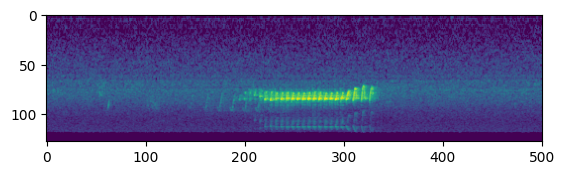

In [68]:
import matplotlib.pyplot as plt

dl = datamodule.train_dataloader()
sample = next(iter(dl))["input_values"][0]

plt.imshow(sample.squeeze().numpy())

### Loading Data Manually

If you want to implement your own data pipeline you can also load the datasets through Hugging Face datasets. This section will detail that aproach.  
Some amount of BirdSet Code will still be used here, so as to not fill up this notebook with helper functions. If you want to, you can look up the used classes and methods under their respective import paths.

In [81]:
from datasets import load_dataset

dataset = load_dataset(
    path="DBD-research-group/BirdSet",
    name="HSN",
    cache_dir="/mnt/stud/work/rantjuschin/datasets/HSN",
    num_proc=4
    )

/mnt/stud/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for DBD-research-group/BirdSet contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/DBD-research-group/BirdSet
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [82]:
print(dataset)
print(dataset["train"][0]["audio"])
print(dataset["train"][0]["detected_events"])

DatasetDict({
    train: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 5460
    })
    test: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 10296
    })
    test_5s: Dataset({
        features: [

#### Preprocessing the Data

You may heave seen that the `audio` column doesn't actually contain any audio data. The loaded dataset as it is, only contains the filepaths of the respective audiosamples. As shown above those files may also contain multiple birdcall events per file which is why it is not encouraged to directly load the whole audio into the sample (it may also just be too big). For BirdSet we typically specify some kind of eventlimit per file and per class and extract and map those events to singular samples in the dataset.

**Please Note:** Only the `train` split needs to be processed this way. Both the `test_5s` and `test` splits do not need to be processed like that.

In [83]:
from datasets import Audio
from birdset.datamodule.components.event_mapping import XCEventMapping

dataset["train"] = dataset["train"].cast_column(
    column="audio",
    feature=Audio(
        sampling_rate=32_000,
        mono=True,
        decode=False,
    ),
)

mapper = XCEventMapping()
dataset["train"] = dataset["train"].map(
    mapper,
    remove_columns=["audio"],
    batched=True,
    batch_size=300,
    num_proc=3,
    desc="Train event mapping"
)

dataset["train"] = dataset["train"].remove_columns("audio")

print(dataset)
print(dataset["train"][0]["filepath"])
print(dataset["train"][0]["detected_events"])

DatasetDict({
    train: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 38170
    })
    test: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 10296
    })
    test_5s: Dataset({
        features: ['audio',

Now every event in the train split has been extracted into it's own sample. If you want to, you can limit these to some amount of events per class or per file.

In [84]:
# smart sampling is defined in the "Helper Functions" section
dataset["train"] = smart_sampling(
    dataset=dataset["train"],
    label_name="ebird_code",
    class_limit=500,
    event_limit=5
)

print(dataset)

sampling: 100%|██████████| 21/21 [00:01<00:00, 11.70it/s]


DatasetDict({
    train: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 17940
    })
    test: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 10296
    })
    test_5s: Dataset({
        features: ['audio',

The last step of this part is to remove unnecessary columns or splits. For BirdSet we use the `test_5s` split for multilabel testing. It contains 5 second long soundscape samples that may contain multiple birds per sample.  
To use it you need to remove the `test` split and rename the `test_5s` split to `test`.

Additionaly the dataset contains multiple columns that are not used and as such can be removed to make it more lightweight.

In [85]:
from datasets import DatasetDict

dataset = DatasetDict({"train": dataset["train"], "test": dataset["test_5s"]})
dataset

DatasetDict({
    train: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 17940
    })
    test: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 12000
    })
})

In [86]:
dataset = dataset.rename_column("ebird_code_multilabel", "labels")
dataset

DatasetDict({
    train: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'labels', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 17940
    })
    test: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'labels', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 12000
    })
})

In [87]:
columns_to_keep = {"filepath", "labels", "detected_events", "start_time", "end_time"}

removable_train_columns = [column for column in dataset["train"].column_names if column not in columns_to_keep]
removable_test_columns = [column for column in dataset["test"].column_names if column not in columns_to_keep]

print(removable_test_columns,"\n", removable_train_columns)

['audio', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'] 
 ['low_freq', 'high_freq', 'ebird_code', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel']


In [88]:
dataset["train"] = dataset["train"].remove_columns(removable_train_columns)
dataset["test"] = dataset["test"].remove_columns(removable_test_columns)

In [89]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'labels', 'detected_events'],
        num_rows: 17940
    })
    test: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'labels', 'detected_events'],
        num_rows: 12000
    })
})


Now the labels need to be one hot encoded for multilabel training.

In [90]:
# classes_one_hot it defined in the "Helper Functions" section
dataset = dataset.map(
                    lambda batch: classes_one_hot(batch, num_classes=21),
                    batched=True,
                    batch_size=300,
                    load_from_cache_file=True,
                    num_proc=4,
                    desc=f"One-hot-encoding labels."
                )

One-hot-encoding labels. (num_proc=4):   0%|          | 0/17940 [00:00<?, ? examples/s]

/tmp/ipykernel_2670041/375418494.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_one_hot_matrix = torch.tensor(class_one_hot_matrix, dtype=torch.float32)
/tmp/ipykernel_2670041/375418494.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_one_hot_matrix = torch.tensor(class_one_hot_matrix, dtype=torch.float32)
/tmp/ipykernel_2670041/375418494.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_one_hot_matrix = torch.tensor(class_one_hot_matrix, dtype=torch.float32)
/tmp/ipykernel_2670041/375418494.py:24: UserWarni

#### Splitting the Data

for better results the `train` split should be split into splits for training and for validation.

In [91]:
from datasets import DatasetDict

splits = dataset["train"].train_test_split(test_size=0.2)

dataset = DatasetDict({"train": splits["train"], "valid": splits["test"], "test": dataset["test"]})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'labels', 'detected_events'],
        num_rows: 14352
    })
    valid: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'labels', 'detected_events'],
        num_rows: 3588
    })
    test: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'labels', 'detected_events'],
        num_rows: 12000
    })
})


#### Applying Transforms

As the datasets can get very big very quickly we suggest applying transforms on-the-fly. That means that transforms are only applied to a batch when it is requested (e.g. by a trainer). With huggingface datasets that is possible through the `set_transform` method. For this you will need a wrapper class that will be able to handle multiple transforms on the data. Here, only a very basic one is implemented but like before you can look up a more sophisticated one in the BirdSet code (`BirdSetTransformsWrapper` in `birdset/datamodule/components/transforms.py`).

##### Decoding & Extracting

As previously mentioned the loaded dataset currently only contains filepaths but to apply transforms or use the data otherwise actual audio data is needed. As the name implies BirdSets `EventDecoding` class takes an event and pulls the associated audio data out of the respective file.

In [92]:
from birdset.datamodule.components.event_decoding import EventDecoding
from birdset.datamodule.components.feature_extraction import DefaultFeatureExtractor

decoder = EventDecoding(
    min_len=1,
    max_len=5,
    sampling_rate=32000,
    extension_time=8,
    extracted_interval=5
)

feature_extractor = DefaultFeatureExtractor(
    feature_size=1,
    sampling_rate=32000,
    padding_value=0.0,
    return_attention_mask=False
)

##### Nocall Sampling

Nocall Sampling uses other soundfiles to introduce samples which don't have any birdcalls in them as such samples are not included by default. To use Nocall Sampling you need to download background noise. BirdSet provides such functionality under `resources/utils/download_background_noise.py`. You will also need this background noise to use `AddBackgroundNoise` in the Waveform Transforms section.

In [93]:
from birdset.datamodule.components.augmentations import NoCallMixer

nocall = NoCallMixer(
    directory="/mnt/stud/work/rantjuschin/datasets/background_noise/",
    p=0.075,
    sampling_rate=32000,
    length=5
)

##### Waveform Transforms

The transform in this section change the input data to ensure that the models learned are more robust.

In [94]:
wav_transforms = []

In [95]:
from birdset.datamodule.components.augmentations import MultilabelMix

multilabel_mix = MultilabelMix(
    p=0.7,
    min_snr_in_db=3.0,
    max_snr_in_db=30.0,
    mix_target="union"
)

wav_transforms.append(multilabel_mix)

/mnt/stud/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/torch_audiomentations/core/transforms_interface.py:77: FutureWarning: Transforms now expect an `output_type` argument that currently defaults to 'tensor', will default to 'dict' in v0.12, and will be removed in v0.13. Make sure to update your code to something like:
  >>> augment = MultilabelMix(..., output_type='dict')
  >>> augmented_samples = augment(samples).samples
  warnings.warn(


In [96]:
from birdset.datamodule.components.augmentations import AddBackgroundNoise

background_noise = AddBackgroundNoise(
    p=0.5,
    min_snr_in_db=3,
    max_snr_in_db=30,
    sample_rate=32000,
    target_rate=32000,
    background_paths="/mnt/stud/work/rantjuschin/datasets/background_noise/"
)

wav_transforms.append(background_noise)

/mnt/stud/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/torch_audiomentations/core/transforms_interface.py:77: FutureWarning: Transforms now expect an `output_type` argument that currently defaults to 'tensor', will default to 'dict' in v0.12, and will be removed in v0.13. Make sure to update your code to something like:
  >>> augment = AddBackgroundNoise(..., output_type='dict')
  >>> augmented_samples = augment(samples).samples
  warnings.warn(


In [97]:
from torch_audiomentations import AddColoredNoise

colored_noise = AddColoredNoise(
    p=0.2,
    max_f_decay=2,
    min_f_decay=-2,
    max_snr_in_db=30,
    min_snr_in_db=3
)

wav_transforms.append(colored_noise)

/mnt/stud/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/torch_audiomentations/core/transforms_interface.py:77: FutureWarning: Transforms now expect an `output_type` argument that currently defaults to 'tensor', will default to 'dict' in v0.12, and will be removed in v0.13. Make sure to update your code to something like:
  >>> augment = AddColoredNoise(..., output_type='dict')
  >>> augmented_samples = augment(samples).samples
  warnings.warn(


In [98]:
from torch_audiomentations import Gain

gain = Gain(
    p=0.2,
    min_gain_in_db=-18,
    max_gain_in_db=6
)

wav_transforms.append(gain)

/mnt/stud/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/torch_audiomentations/core/transforms_interface.py:77: FutureWarning: Transforms now expect an `output_type` argument that currently defaults to 'tensor', will default to 'dict' in v0.12, and will be removed in v0.13. Make sure to update your code to something like:
  >>> augment = Gain(..., output_type='dict')
  >>> augmented_samples = augment(samples).samples
  warnings.warn(


##### Spectrogramm Processing

As ConvNeXT needs spectrogramm data as input, the waveform need to turned into spectrogramms. These steps are configured here.

In [99]:
from torchaudio.transforms import Spectrogram

spectrogramm_conversion = Spectrogram(
    n_fft=1024,
    hop_length=320,
    power=2.0
)

In [100]:
from torchaudio.transforms import MelScale

melscale_conversion = MelScale(
    n_mels=128,
    sample_rate=32000,
    n_stft=513
)

In [101]:
from birdset.datamodule.components.augmentations import PowerToDB

dbscale_conversion = PowerToDB()

In [102]:
from birdset.datamodule.components.resize import Resizer

resizer = Resizer(
    db_scale=True,
    target_height=None,
    target_width=None
)

In [103]:
processing_config = CustomProcessingConfig(
    spectrogram_conversion=spectrogramm_conversion,
    resizer=resizer,
    melscale_conversion=melscale_conversion,
    dbscale_conversion=dbscale_conversion,
    normalize_spectrogram=True,
    mean=-4.268,
    std=4.569
)

##### Spectrogram Transformation

Like with the waveform transforms before the spectrogramms are also transformed to ensure more robust models.

In [104]:
spec_transforms = []

In [105]:
from torchvision.transforms import RandomApply
from torchaudio.transforms import FrequencyMasking

frequency_masking = RandomApply(
    p=0.5,
    transforms=[
        FrequencyMasking(
            freq_mask_param=100,
            iid_masks=True
        )
    ]
)

spec_transforms.append(frequency_masking)

In [106]:
from torchvision.transforms import RandomApply
from torchaudio.transforms import TimeMasking

time_masking = RandomApply(
    p=0.5,
    transforms=[
        TimeMasking(
            time_mask_param=100,
            iid_masks=True
        )
    ]
)

spec_transforms.append(time_masking)

##### On The Fly Transforming

As mentioned we want to apply the transforms on a batch only as it is getting processed. To achieve that behaviour we use the `set_transform` method of huggingface datatets. The test data does not get transformed using waveform and spectrogramm transformations. It only gets processed so that it can be used by the model.

In [107]:
transforms = BasicTransformsWrapper(
    wav_transforms=wav_transforms,
    spec_transforms=spec_transforms,
    decoding=decoder,
    feature_extractor=feature_extractor,
    processing_config=processing_config,
    nocall_sampler=nocall
)

dataset["train"].set_transform(transforms, output_all_columns=False)
dataset["valid"].set_transform(transforms, output_all_columns=False)

test_transforms = BasicTransformsWrapper(
    wav_transforms=[],
    spec_transforms=[],
    decoding=decoder,
    feature_extractor=feature_extractor,
    processing_config=processing_config,
    nocall_sampler=None
)

dataset["test"].set_transform(test_transforms, output_all_columns=False)

#### Wrapping the Data in a Datamodule

To use hte previously configured dataset in a trainer it needs to be wrapped in a datamodule. The datamodule provides dataloaders that are needed by the trainer.

In [108]:
datamodule = CustomDatamodule(dataset=dataset, batch_size=32, num_workers=8, num_classes=21, task="multilabel")

In [109]:
datamodule.dataset

DatasetDict({
    train: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'labels', 'detected_events'],
        num_rows: 14352
    })
    valid: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'labels', 'detected_events'],
        num_rows: 3588
    })
    test: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'labels', 'detected_events'],
        num_rows: 12000
    })
})

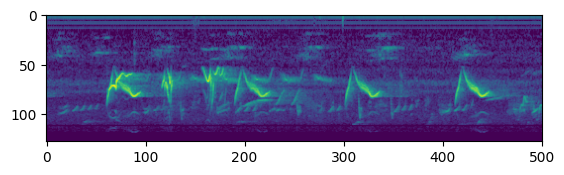

In [110]:
import matplotlib.pyplot as plt

dl = datamodule.train_dataloader()
sample = next(iter(dl))["input_values"][0]

plt.imshow(sample.squeeze().numpy())

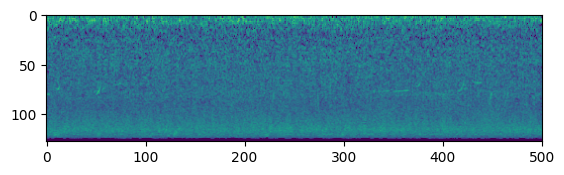

In [111]:
test_loader = datamodule.test_dataloader()
sample = next(iter(test_loader))

plt.imshow(sample["input_values"][2].squeeze().numpy())

## Setting up a Model

### Using BirdSet's Pretrained Models with BirdSet

Here the ConvNeXT model pretrained on XCL by BirdSet is loaded. For more information regarding BirdSet's modules please refer to the `birdset-pipeline_tutorial` notebook.

In [15]:
from birdset.modules.models.convnext import ConvNextClassifier
from birdset.modules.multilabel_module import MultilabelModule
from birdset.configs import NetworkConfig, LRSchedulerConfig, MultilabelMetricsConfig, LoggingParamsConfig

network = NetworkConfig(
    model=ConvNextClassifier(
        checkpoint="DBD-research-group/ConvNeXT-Base-BirdSet-XCL",
        num_classes=datamodule.num_classes,
        num_channels=1,
    ),
    model_name="convnext",
    model_type="vision"
)

model = MultilabelModule(
    network=network,
    num_epochs=5,
    len_trainset=datamodule.len_trainset,
    task=datamodule.task,
    batch_size=datamodule.train_batch_size
)

model

Using the latest cached version of the module from /mnt/stud/home/rantjuschin/.cache/huggingface/modules/datasets_modules/datasets/DBD-research-group--BirdSet/c6d7d1c30e4d8f29c4fb5e358bc605ccb896681b869398c54db64721f45ac91e (last modified on Tue Jan 14 12:41:25 2025) since it couldn't be found locally at DBD-research-group/BirdSet, or remotely on the Hugging Face Hub.
Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at DBD-research-group/ConvNeXT-Base-BirdSet-XCL and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9736]) in the checkpoint and torch.Size([21]) in the model instantiated
- classifier.weight: found shape torch.Size([9736, 1024]) in the checkpoint and torch.Size([21, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/mnt/stud/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-p

MultilabelModule(
  (loss): BCEWithLogitsLoss()
  (model): ConvNextClassifier(
    (model): ConvNextForImageClassification(
      (convnext): ConvNextModel(
        (embeddings): ConvNextEmbeddings(
          (patch_embeddings): Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
          (layernorm): ConvNextLayerNorm()
        )
        (encoder): ConvNextEncoder(
          (stages): ModuleList(
            (0): ConvNextStage(
              (downsampling_layer): Identity()
              (layers): Sequential(
                (0): ConvNextLayer(
                  (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
                  (layernorm): ConvNextLayerNorm()
                  (pwconv1): Linear(in_features=128, out_features=512, bias=True)
                  (act): GELUActivation()
                  (pwconv2): Linear(in_features=512, out_features=128, bias=True)
                  (drop_path): Identity()
                )
                (1): Con

### Loading Models through Hugging Face

Loading a model through Hugging Face and then training it using a Lightning trainer is a bit more work as the trainer expects a `LightningModule`. This means that we need to wrap the model in such a module.

In [112]:
# ConvNextClassifierLightningModule is a custom class defined in the "Helper" section
# HSN contains 21 classes
model = ConvNextClassifierLightningModule(21, num_epochs=5)
model

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at DBD-research-group/ConvNeXT-Base-BirdSet-XCL and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9736]) in the checkpoint and torch.Size([21]) in the model instantiated
- classifier.weight: found shape torch.Size([9736, 1024]) in the checkpoint and torch.Size([21, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ConvNextClassifierLightningModule(
  (model): ConvNextForImageClassification(
    (convnext): ConvNextModel(
      (embeddings): ConvNextEmbeddings(
        (patch_embeddings): Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
        (layernorm): ConvNextLayerNorm()
      )
      (encoder): ConvNextEncoder(
        (stages): ModuleList(
          (0): ConvNextStage(
            (downsampling_layer): Identity()
            (layers): Sequential(
              (0): ConvNextLayer(
                (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
                (layernorm): ConvNextLayerNorm()
                (pwconv1): Linear(in_features=128, out_features=512, bias=True)
                (act): GELUActivation()
                (pwconv2): Linear(in_features=512, out_features=128, bias=True)
                (drop_path): Identity()
              )
              (1): ConvNextLayer(
                (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1

## Starting Fine-Tuning with a Lightning Trainer

Now that the model and dataset are loaded the trainer needs to be configured. As before the trainer here is configured similar to how it would be in a BirdSet training although it is simplified for the use in this notebook. The `ModelCheckpoint` callback allows the easy selection of models after the evaluation.

Please note that the trainer is configured to only two epochs of training and validation. If you get errors regarding the usage of hardware resources you can try to lower the batch size or the numver of workers in the datamodules.

In [113]:
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import RichModelSummary

model_checkpoint = ModelCheckpoint(
    dirpath="/mnt/stud/work/rantjuschin/callback_checkpoints",
    monitor="val/BCEWithLogitsLoss",
    verbose=False,
    save_last=False,
    save_top_k=2,
    mode="min",
    auto_insert_metric_name=False,
    save_weights_only=False,
    every_n_train_steps=None,
    train_time_interval=None,
    every_n_epochs=1,
    save_on_train_epoch_end=None,
)

rich_model_summary = RichModelSummary(max_depth=1)

trainer = L.Trainer(
    min_epochs=1,
    max_epochs=2,
    gradient_clip_val=0.5,
    precision=16,
    accumulate_grad_batches=1,
    callbacks=[model_checkpoint, rich_model_summary]
)

/mnt/stud/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Now that the trainer is configured the model can be fine-tuned.

In [114]:
trainer.fit(datamodule=datamodule, model=model)

/mnt/stud/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /mnt/stud/work/rantjuschin/callback_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/stud/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                           ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ ConvNextForImageClassification │ 87.6 M │ eval  │
│ 1 │ loss          │ BCEWithLogitsLoss              │      0 │ train │
│ 2 │ main_metric   │ cmAP                           │      0 │ train │
│ 3 │ other_metrics │ MetricCollection               │      0 │ train │
└───┴───────────────┴────────────────────────────────┴────────┴───────┘

Trainable params: 87.6 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 87.6 M                                                                                               
Total estimated model params size (MB): 350                                                                        
Modules in train mode: 5                                                                                           
Modules in eval mode: 279

SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [115]:
trainer.callback_metrics

{'train/BCEWithLogitsLoss': tensor(0.1029),
 'train/BCEWithLogitsLoss_step': tensor(0.0662),
 'val/BCEWithLogitsLoss': tensor(0.0908),
 'val/BCEWithLogitsLoss_epoch': tensor(0.0908),
 'train/BCEWithLogitsLoss_epoch': tensor(0.1029)}

In [116]:
ckpt_path = trainer.checkpoint_callback.best_model_path
ckpt_path

'/mnt/stud/work/rantjuschin/callback_checkpoints/1-898-v5.ckpt'

In [117]:
trainer.test(datamodule=datamodule, model=model, ckpt_path=ckpt_path)

Restoring states from the checkpoint path at /mnt/stud/work/rantjuschin/callback_checkpoints/1-898-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/stud/work/rantjuschin/callback_checkpoints/1-898-v5.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

/mnt/stud/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
/mnt/stud/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      MultilabelAUROC      │    0.9078963398933411     │
│        T1Accuracy         │    0.5317091345787048     │
│  test/BCEWithLogitsLoss   │    0.08642188459634781    │
│         test/cmAP         │    0.44796881079673767    │
└───────────────────────────┴───────────────────────────┘

[{'test/BCEWithLogitsLoss': 0.08642188459634781,
  'test/cmAP': 0.44796881079673767,
  'MultilabelAUROC': 0.9078963398933411,
  'T1Accuracy': 0.5317091345787048}]